In [20]:
import pandas as pd
import torch
import numpy as np
import pywt
import sys
import os
import matplotlib.pyplot as plt
from typing import Optional
from pydantic import BaseModel
from abc import ABC

# Adiciona o diretório raiz ao sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))

In [16]:
from ThreeWToolkit.feature_extraction import extract_wavelet_features

Sample DataFrame created. Shape: (200, 2)


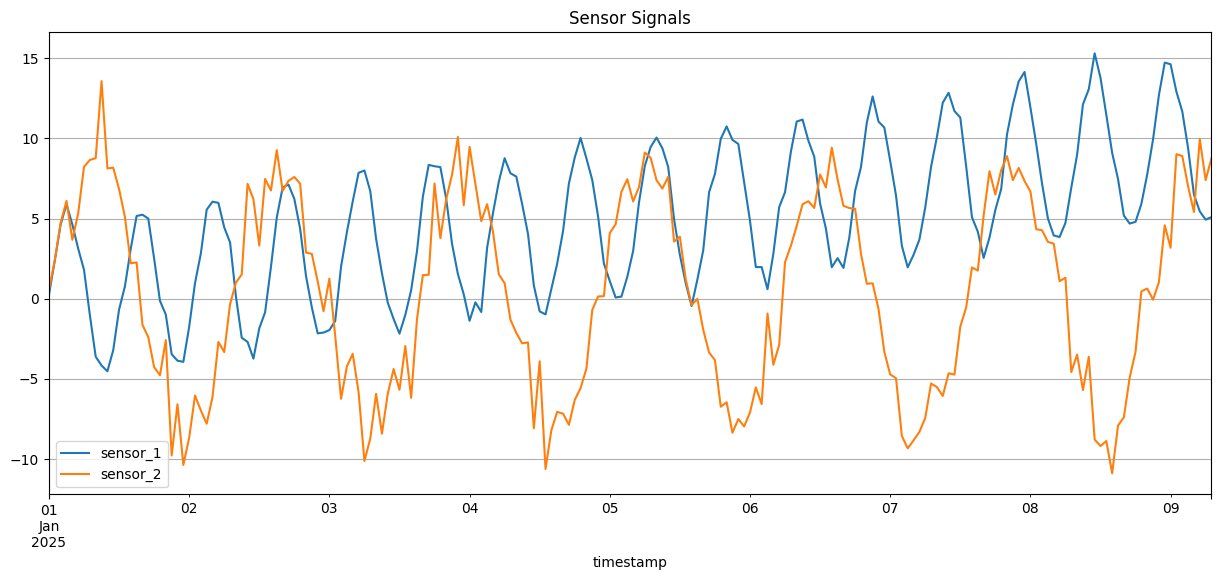

In [17]:
# Generate a time index
data_points = 200
time_index = pd.date_range(start='2025-01-01', periods=data_points, freq='h')

# Create sample signals
np.random.seed(42) # for reproductbility
time_vector = np.arange(data_points)

# Sensor 1: Linear trend + Sine wave + Noise
signal1 = 0.05 * time_vector + 5 * np.sin(time_vector * 0.5) + np.random.randn(data_points) * 0.5

# Sensor 2: Just a noisier Sine wave
signal2 = 8 * np.sin(time_vector * 0.2) + np.random.randn(data_points) * 1.5

# Create DataFrame
sample_df = pd.DataFrame(
    {'sensor_1': signal1, 'sensor_2': signal2},
    index=time_index
)
sample_df.index.name = 'timestamp'

# Plot the original signals
print("Sample DataFrame created. Shape:", sample_df.shape)
sample_df.plot(figsize=(15, 6), title='Sensor Signals', grid=True)
plt.show()

### Wavelet Feature Extraction

In [18]:
# 1. Configure the extractor
# level=3 means our window size will be 2^3 = 8 points.
# stride=1 means we slide the window one point at a time.
config = extract_wavelet_features.WaveletConfig(level=3, stride=1, offset=0)

# 2. Instantiate the extractor
feature_extractor = extract_wavelet_features.ExtractWaveletFeatures(config)

# 3. Apply it to our data
wavelet_features = feature_extractor(sample_df)

# Display the first few rows of the result
print("Shape of the extracted features:", wavelet_features.shape)
print("\nColumns are named as <sensor_name>_<feature>_<level>.")
print("Ex: sensor_1_A3 is the level 3 approximation coefficient for sensor 1.")

wavelet_features.head()

Shape of the extracted features: (193, 14)

Columns are named as <sensor_name>_<feature>_<level>.
Ex: sensor_1_A3 is the level 3 approximation coefficient for sensor 1.


,sensor_1_A3,sensor_2_A3,sensor_1_D3,sensor_2_D3,sensor_1_A2,sensor_2_A2,sensor_1_D2,sensor_2_D2,sensor_1_A1,sensor_2_A1,sensor_1_D1,sensor_2_D1,sensor_1_A0,sensor_2_A0
timestamp,,,,,,,,,,,,,,
2025-01-01 07:00:00,7.667248,14.030942,-1.635832,4.269348,4.264855,12.940259,-3.489848,3.942884,0.548013,11.938184,-1.990792,0.300811,-1.020199,8.654277
2025-01-01 08:00:00,6.300019,16.941563,-6.100933,4.962720,0.140775,15.488667,-4.779724,1.934771,-3.280232,12.320231,-1.837453,0.081235,-3.618750,8.769160
2025-01-01 09:00:00,3.986236,20.879917,-8.943135,6.854354,-3.505056,19.611090,-4.280064,2.727948,-5.504911,15.796086,-0.387226,3.394620,-4.166371,13.569878
2025-01-01 10:00:00,0.748561,22.078742,-10.175460,5.586125,-6.665825,19.562015,-2.026876,2.138578,-6.146668,15.344637,-0.254530,-3.846069,-4.526330,8.130715
2025-01-01 11:00:00,-2.472154,22.811827,-8.503570,4.511538,-7.761008,19.320537,0.024112,-3.018502,-5.470812,11.527279,0.930385,0.028712,-3.210567,8.171320


In [19]:
# Configure with an offset
config_offset = extract_wavelet_features.WaveletConfig(level=3, stride=1, offset=20)
extractor_offset = extract_wavelet_features.ExtractWaveletFeatures(config_offset)
features_offset = extractor_offset(sample_df)

print("--- No offset ---")
print("Start index:", wavelet_features.index[0])

print("\n--- Using offset=20 ---")
print("Start index with offset:", features_offset.index[0])
print("Extraction began 20 points later, so the first timestamp is delayed.")

features_offset.head()

--- No offset ---
Start index: 2025-01-01 07:00:00

--- Using offset=20 ---
Start index with offset: 2025-01-02 03:00:00
Extraction began 20 points later, so the first timestamp is delayed.


,sensor_1_A3,sensor_2_A3,sensor_1_D3,sensor_2_D3,sensor_1_A2,sensor_2_A2,sensor_1_D2,sensor_2_D2,sensor_1_A1,sensor_2_A1,sensor_1_D1,sensor_2_D1,sensor_1_A0,sensor_2_A0
timestamp,,,,,,,,,,,,,,
2025-01-02 03:00:00,-1.645284,-20.786499,7.019935,-0.062639,3.800453,-14.742567,4.581657,-0.027384,5.927046,-10.443932,1.931415,-0.585142,5.556771,-7.798733
2025-01-02 04:00:00,0.843732,-22.038310,10.051849,2.995212,7.704339,-13.465504,3.905149,-0.456318,8.209148,-9.844215,0.350687,1.184860,6.052717,-6.123089
2025-01-02 05:00:00,4.181274,-19.536537,10.253219,2.855563,10.206728,-11.795230,1.824618,2.974720,8.507446,-6.237042,-0.052389,2.422313,5.978628,-2.697421
2025-01-02 06:00:00,7.121697,-18.386586,8.462019,4.279723,11.019351,-9.975058,-0.590137,3.946763,7.374568,-4.262648,-1.080489,-0.447919,4.450586,-3.330874
2025-01-02 07:00:00,9.755002,-14.840949,4.380351,6.008188,9.995204,-6.245705,-2.036142,2.574804,5.627907,-2.595719,-0.666172,2.114848,3.508477,-0.340027
